# Support Vector Machine (SVM) 

To support the lecture 12 in Statistical Inference and Modeling 2102575 by *Suwichaya Suwanwimolkul, Ph.D.*

## Data visualization

- [Download the data](#downloading-data) 
- [Label histogram](#populations-in-each-class)
- [Feature correlation](#feature-correlation)
- [Scatter plot of features](#scatter-plot-of-features)

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt  

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn import metrics  
import seaborn as sns

def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed) 
    perm         = np.random.permutation(df.index)
    m            = len(df.index) 
    train_end    = int(np.floor(int(train_percent * m)))
    validate_end = int(np.floor(int(validate_percent * m) + train_end)) 
    
    train        = df.iloc[perm[:train_end]]
    validate     = df.iloc[perm[train_end:validate_end]]
    test         = df.iloc[perm[validate_end:]] 
 

    train       = train.reset_index(drop=True)
    validate    = validate.reset_index(drop=True)
    test        = test.reset_index(drop=True)
    
    return train, validate, test

### Downloading data

In [2]:
foldername = "iris" 
df_loaded = pd.read_csv('%s/iris_synthetic_data.csv' % foldername)   
df_loaded.keys()

label_string = np.unique(df_loaded['label'].values).tolist() 
binary_label = [label_string[1], label_string[2]]


df_1 = df_loaded.loc[df_loaded['label'] == binary_label[0]]
df_2 = df_loaded.loc[df_loaded['label'] == binary_label[1]]

df   = pd.concat([df_1, df_2], ignore_index=True) 

target_column = ['label']
feat_column   = ['sepal length', 'petal width'] # 'sepal length', 'sepal width', 'petal length', 'petal width'

all_column =  target_column + feat_column
df = df[all_column]
df = df.apply(LabelEncoder().fit_transform)

train_df, test_df, valid_df = train_validate_test_split(df, train_percent=.8, validate_percent=.1, seed=None)

X_scaler = StandardScaler() 
train_df[feat_column].values[:]        = X_scaler.fit_transform(train_df[feat_column].values[:] )
test_df[feat_column].values[:]         = X_scaler.transform(test_df[feat_column].values[:] )
valid_df[feat_column].values[:]        = X_scaler.transform(valid_df[feat_column].values[:] )


all_column = target_column + feat_column
train_enc = train_df[all_column]

print("# Training   dataset: %d" % len(train_df))
print("# Testing    dataset: %d" % len(test_df))
print("# Validating dataset: %d" % len(valid_df))

# Training   dataset: 1600
# Testing    dataset: 200
# Validating dataset: 200


### Populations in each class

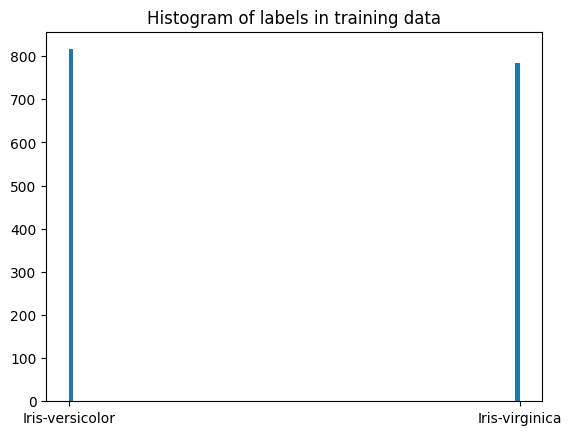

In [3]:
train_enc_array = train_enc[target_column].values
 
plt.hist(train_enc_array, bins=100)  # arguments are passed to np.histogram
plt.title("Histogram of labels in training data")
plt.xticks(np.unique(train_enc[target_column].values).tolist(), binary_label,  rotation=0)
plt.show()

### Feature correlation

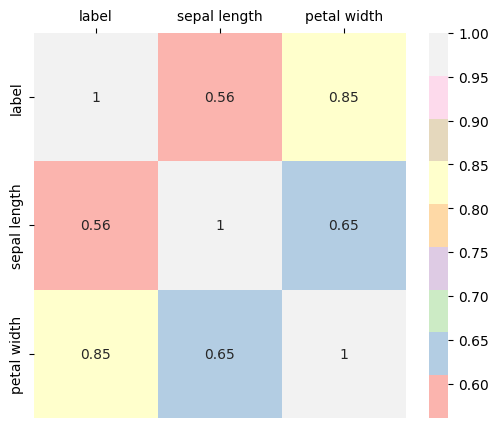

In [4]:
plt.figure(figsize=(6, 5))
cor = train_enc.corr()
g = sns.heatmap(cor, annot=True, cmap=plt.cm.Pastel1) 
g.axes.xaxis.set_ticks_position("top")
plt.setp(g.axes.get_xticklabels(), rotation=0)
plt.show()

### Scatter plot of features

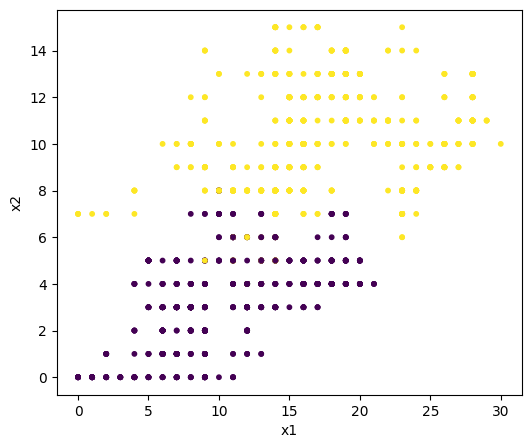

In [5]:
x1 = train_enc[feat_column[0]].values
x2 = train_enc[feat_column[1]].values
y  = train_enc[target_column].values

plt.figure(figsize=(6, 5))   
plt.scatter(x1, x2, c=y, s=10 )
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

## Training SVM model

In this experiment, we will investigate 

- how the learned model has changed as the regularization parameter $C$ increases or decreases... 
- then, explain the differences in the support hyperplanes and the target hyperplane. 

<img src="figs/svm.png">

Set the C value in the code below:  

- C  = 1000
- C  = 0.001

In [6]:
C = 1000  
# C = 0.001  

In [7]:
from sklearn import svm

X_train = train_enc[feat_column].values
y_train = train_enc[target_column].values

clf = svm.SVC(kernel='linear', C=C)  
clf.fit(X_train, y_train)


/home/gaap/anaconda3/envs/EE575/lib/python3.13/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1000, kernel='linear')

## Visualizing the learned SVM model

Below we provide the following tools for visualization:

- plotting_decision_contour(X_train): to provide the decision boundary for each class. 
- plotting_hyperplanes(X_train, W, b, margin): to provide the plots for the support and target hyperplanes

In [8]:
def plotting_decision_contour(X_train):
    h = 0.02  # step size in the mesh
    x1_min, x1_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    x2_min, x2_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h), np.arange(x2_min, x2_max, h))
    Z = clf.predict(np.c_[xx1.ravel(), xx2.ravel()])  
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, cmap=plt.cm.Pastel2)

In [9]:
def plotting_hyperplanes(X_train, W, b, margin):
    X1 =  X_train[:, 0]
    X2 =  (-W[0,0]*X1 - b[0])/W[0,1]
    plt.plot(X1, X2, "r-") 
    plt.plot(X1, X2 - margin/W[0,1], "r--") 
    plt.plot(X1, X2 + margin/W[0,1], "r--") 


### Check the number of supports

In [10]:
print("# supports = %d out of all points %d" % (clf.support_vectors_.shape[0], X_train.shape[0]))

# supports = 167 out of all points 1600


### Check how the model is shaped by the training data

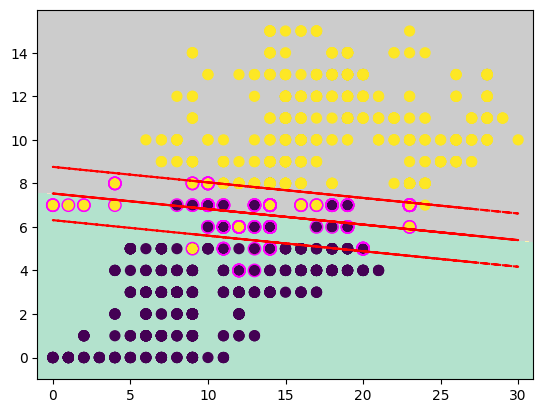

In [11]:
from sklearn.inspection import DecisionBoundaryDisplay

W = clf.coef_
b = clf.intercept_ 
margin = 1/np.linalg.norm(clf.coef_)

plotting_hyperplanes(X_train, W, b, margin) 

plotting_decision_contour(X_train) 

plt.scatter(
        X_train[:, 0], X_train[:, 1], c=y_train, s=50 )

plt.scatter(
        clf.support_vectors_[:, 0],
        clf.support_vectors_[:, 1],
        s=80,
        facecolors="none", 
        edgecolors="magenta",
    )

## Evaluation

In the following, we use the learned model to predict the label by running

`y_pred = clf.predict(X_test) `

Then, we calculate the confusion matrix to evaluate the model performance.

`confusion_matrix(y_test, y_pred)`

Finally, we visualize the testing data samples compared to the decision boundary of the trained model. 

In [12]:
X_test = test_df[feat_column].values
y_test = test_df[target_column].values.reshape(-1)

y_pred = clf.predict(X_test) 

In [13]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[ 79,   4],
       [  4, 113]])

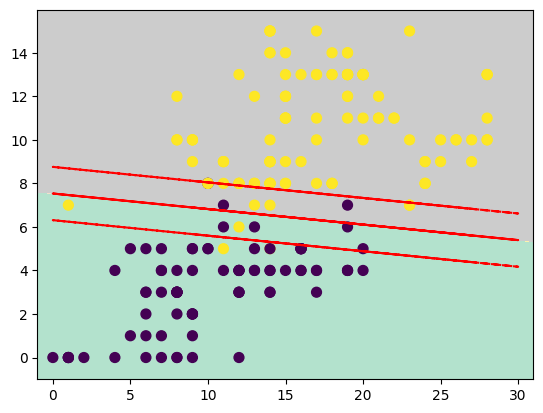

In [14]:
plotting_hyperplanes(X_train, W, b, margin) 

plotting_decision_contour(X_train) 

plt.scatter( X_test[:, 0], X_test[:, 1], c=y_test,  s=50)